In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV, RidgeCV
from sklearn.metrics import r2_score
from sklearn.linear_model import lars_path
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection, metrics   
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from xgboost import plot_tree
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm
import math
from dtreeviz.trees import *
import shap
sns.set(rc={'figure.figsize':(10,10)})


In [2]:
#import dataset

df = pd.read_csv("salary_final.csv")

In [3]:


df.shape

(1303, 22)

In [4]:
#check for any Nan Values 

df=df.dropna()
df.shape

(1303, 22)

<AxesSubplot:xlabel='Salary', ylabel='Count'>

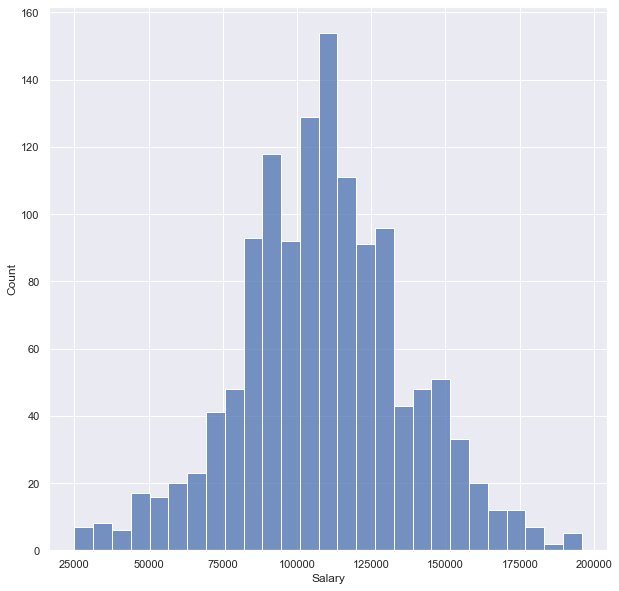

In [5]:
#histogram of base pay 

sns.histplot(data=df, x="Salary")

In [6]:
df.dtypes

Size                  int64
Revenue               int64
Internship            int64
Cash_Bonus            int64
Stock_Bonus           int64
Total_Pay             int64
Confidence            int64
Reviews               int64
Jobs                  int64
Salaries              int64
Interviews          float64
Benefits              int64
Salary              float64
Company_Type         object
US                   object
COL                 float64
Rent                float64
COL_Plus_Rent       float64
Purchasing_Power    float64
Industry_            object
Age                 float64
Additional_Pay        int64
dtype: object

In [7]:
#standardize numerical variables

num_cols = ["Size","Revenue","Internship","Cash_Bonus","Stock_Bonus","Total_Pay","Confidence",
            "Reviews","Jobs","Salaries","Interviews","Benefits","COL","Rent",
            "COL_Plus_Rent","Purchasing_Power","Age","Additional_Pay" ]
std = StandardScaler()
std.fit(df[num_cols].values)

#apply

df[num_cols]= std.transform(df[num_cols].values)

In [8]:

#drop NA from df and make dummy variables for categorical predictors 

df_model = pd.get_dummies(df, drop_first = True)
df_model.head()

,Size,Revenue,Internship,Cash_Bonus,Stock_Bonus,Total_Pay,Confidence,Reviews,Jobs,Salaries,...,Purchasing_Power,Age,Additional_Pay,Company_Type_Company - Public,Company_Type_Other,US_NORTH_EAST,US_SOUTH,US_WEST,Industry__Other,Industry__Technology
0,0.752695,0.682933,-0.362045,0.626814,0.626814,1.225633,1.440485,1.577339,0.445617,-0.362043,...,0.152482,1.094338,1.123456,1,0,1,0,0,1,0
1,0.752695,0.890893,-0.362045,-0.218842,-0.218842,0.577148,1.440485,0.319054,-0.528353,1.015915,...,0.152482,0.403677,1.123456,0,1,1,0,0,1,0
2,0.752695,0.682933,-0.362045,-0.443515,-0.443515,0.520143,1.440485,1.958638,-0.297863,-0.492039,...,0.152482,0.905976,-0.890111,1,0,1,0,0,0,1
3,-1.707822,-1.604630,-0.362045,-0.005180,-0.005180,0.323330,1.440485,-0.881274,-0.537708,-0.758791,...,0.152482,-0.747425,1.123456,0,0,1,0,0,1,0
4,0.752695,0.890893,-0.362045,-0.443515,-0.443515,0.887780,1.440485,2.073028,0.782372,-0.284046,...,0.152482,0.571110,-0.890111,1,0,1,0,0,1,0


In [9]:

df_model.shape

(1303, 26)

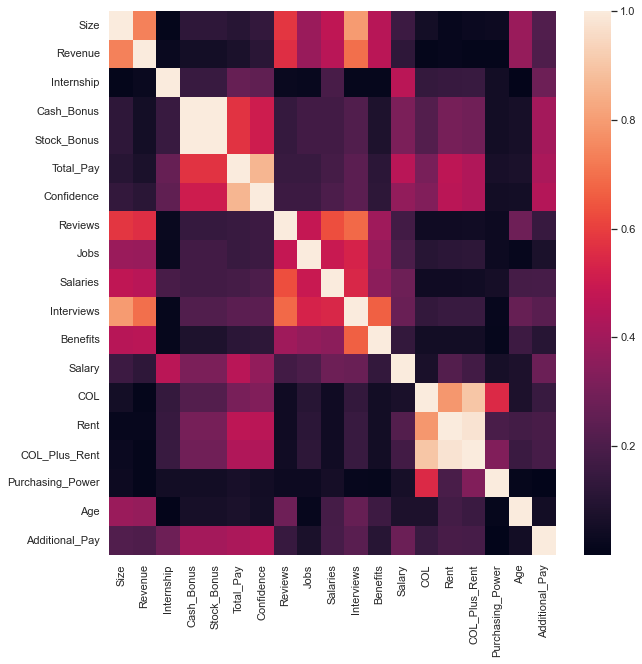

In [10]:
df_corr = df.corr().abs()
hm = sns.heatmap(df_corr)
figure = hm.get_figure()  
figure.savefig('heatmap.png', dpi=400)

In [11]:
#define X and y 

X = df_model.drop( "Salary", axis = 1)
y = df_model["Salary"]

In [12]:
#create a correlation df for the features 

X_corr = X.corr().abs()

In [13]:
#get list of correlations amongst features 

X_corr_list = X_corr.unstack().sort_values(ascending=False).drop_duplicates()
X_corr_list.head(25)

Size                           Size                             1.000000
COL_Plus_Rent                  Rent                             0.977010
                               COL                              0.901535
Total_Pay                      Confidence                       0.860908
Size                           Interviews                       0.795082
Rent                           COL                              0.788558
Size                           Revenue                          0.735535
Industry__Other                Industry__Technology             0.719665
Interviews                     Revenue                          0.695417
                               Reviews                          0.685647
Benefits                       Interviews                       0.667007
Reviews                        Salaries                         0.631153
                               Size                             0.582069
Cash_Bonus                     Total_Pay           

In [14]:


#Getting list of highly correlated features 
correlated_features = set()
for i in range(len(X_corr.columns)):
    for j in range(i):
        if abs(X_corr.iloc[i, j]) > 0.7:
            colname = X_corr.columns[i]
            correlated_features.add(colname)
print(correlated_features)

{'Stock_Bonus', 'Rent', 'COL_Plus_Rent', 'Confidence', 'Industry__Technology', 'Revenue', 'Interviews'}


In [15]:
#dropping highly correlated features from the training set 
corr_features = [ 'COL_Plus_Rent', 'Rent', 'Interviews', 'Stock_Bonus', 'Industry__Other', 'Confidence']
X.drop(corr_features, axis=1, inplace=True)
X.head()


,Size,Revenue,Internship,Cash_Bonus,Total_Pay,Reviews,Jobs,Salaries,Benefits,COL,Purchasing_Power,Age,Additional_Pay,Company_Type_Company - Public,Company_Type_Other,US_NORTH_EAST,US_SOUTH,US_WEST,Industry__Technology
0,0.752695,0.682933,-0.362045,0.626814,1.225633,1.577339,0.445617,-0.362043,0.363869,-0.330475,0.152482,1.094338,1.123456,1,0,1,0,0,0
1,0.752695,0.890893,-0.362045,-0.218842,0.577148,0.319054,-0.528353,1.015915,-0.151989,-0.330475,0.152482,0.403677,1.123456,0,1,1,0,0,0
2,0.752695,0.682933,-0.362045,-0.443515,0.520143,1.958638,-0.297863,-0.492039,0.466733,-0.330475,0.152482,0.905976,-0.890111,1,0,1,0,0,1
3,-1.707822,-1.604630,-0.362045,-0.005180,0.323330,-0.881274,-0.537708,-0.758791,-0.642645,-0.330475,0.152482,-0.747425,1.123456,0,0,1,0,0,0
4,0.752695,0.890893,-0.362045,-0.443515,0.887780,2.073028,0.782372,-0.284046,0.466733,-0.330475,0.152482,0.571110,-0.890111,1,0,1,0,0,0


In [16]:
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [17]:
X.shape

(1303, 19)

In [18]:
X_vif = vif(X)
X_vif.sort_values(ascending=False)

Company_Type_Company - Public    2.903374
COL                              2.739488
Size                             2.720427
Revenue                          2.661250
Reviews                          2.304607
US_WEST                          2.134534
US_NORTH_EAST                    2.036431
Salaries                         2.029292
Total_Pay                        1.973496
Industry__Technology             1.862700
Purchasing_Power                 1.832369
Cash_Bonus                       1.621036
US_SOUTH                         1.598151
Jobs                             1.573933
Internship                       1.439336
Additional_Pay                   1.439081
Age                              1.434002
Benefits                         1.427150
Company_Type_Other               1.373526
dtype: float64

In [19]:
#remove high inflation factors
high_vif = []
X.drop(high_vif, axis=1, inplace=True)
X.head()

,Size,Revenue,Internship,Cash_Bonus,Total_Pay,Reviews,Jobs,Salaries,Benefits,COL,Purchasing_Power,Age,Additional_Pay,Company_Type_Company - Public,Company_Type_Other,US_NORTH_EAST,US_SOUTH,US_WEST,Industry__Technology
0,0.752695,0.682933,-0.362045,0.626814,1.225633,1.577339,0.445617,-0.362043,0.363869,-0.330475,0.152482,1.094338,1.123456,1,0,1,0,0,0
1,0.752695,0.890893,-0.362045,-0.218842,0.577148,0.319054,-0.528353,1.015915,-0.151989,-0.330475,0.152482,0.403677,1.123456,0,1,1,0,0,0
2,0.752695,0.682933,-0.362045,-0.443515,0.520143,1.958638,-0.297863,-0.492039,0.466733,-0.330475,0.152482,0.905976,-0.890111,1,0,1,0,0,1
3,-1.707822,-1.604630,-0.362045,-0.005180,0.323330,-0.881274,-0.537708,-0.758791,-0.642645,-0.330475,0.152482,-0.747425,1.123456,0,0,1,0,0,0
4,0.752695,0.890893,-0.362045,-0.443515,0.887780,2.073028,0.782372,-0.284046,0.466733,-0.330475,0.152482,0.571110,-0.890111,1,0,1,0,0,0


In [20]:
#get shape of  X and y 

print(X.shape, y.shape)


(1303, 19) (1303,)


In [21]:
#partition data into test data 

X, X_test, y, y_test = train_test_split(X, y, test_size = .2, random_state = 133)

#partition remaining data into train / validation


X_train, X_val, y_train, y_val = train_test_split (X, y, test_size= .25, random_state = 133)

print( X_test.shape, X_train.shape, X_val.shape)

(261, 19) (781, 19) (261, 19)


In [22]:
#define mae 
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [23]:
#create df to store results
cols = ["TEST","FEAT", "OBS","ALPHA", "MAE", "RMSE", "R2", "ADJ_R2"]
results_df = pd.DataFrame(columns=cols)
results_df.head()

,TEST,FEAT,OBS,ALPHA,MAE,RMSE,R2,ADJ_R2


In [24]:
#Tuning Parameters for XG Boost 

#Convert data into DMatrix
glass_dmatrix = xgb.DMatrix(data = X_train, label = y_train)

# Grid of hyperparameters to search over
param_random_gb = {'learning_rate': np.arange(0.05,1.05, 0.05),
              'n_estimators' : [200],
              'subsample' : np.arange(0.05,1.05, 0.05),
                   'alpha': (0.05, 0.1, 0.2, 0.3, 0.5)
                   }

# Regressor Instantiation
gb = xgb.XGBRegressor()

# 25 iterations
mse_random = RandomizedSearchCV(estimator = gb, param_distributions = param_random_gb, n_iter = 25, 
                                scoring = 'neg_mean_squared_error', cv = 4, verbose = 1)

mse_random.fit(X,y)

print("Best parameter: ", mse_random.best_params_)
print("Lowest RMSE: ", np.sqrt(np.abs(mse_random.best_score_)))

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best parameter:  {'subsample': 0.6000000000000001, 'n_estimators': 200, 'learning_rate': 0.05, 'alpha': 0.3}
Lowest RMSE:  18647.3886654186


In [25]:
#Train XG Boost Model
xgbr = xgb.XGBRegressor(verbosity=0, eta=0.1, sub_sample=0.55, n_estimators=200,
                        alpha=0.1) 
xgbr.fit(X_train, y_train)


#Create kFold cross-val score 
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )

#predict y values 
y_pred = xgbr.predict(X_val)

#derive mse, score, mae and adjusted r2
xgbr_mse = mean_squared_error(y_val, y_pred)
xgbr_rmse = math.sqrt(xgbr_mse)


score = xgbr.score(X_val, y_val)
xgbr_mae = mae(y_val, y_pred)

#get adjust r2 for the model 
#Adj r2 = 1-(1-R2)*(n-1)/(n-p-1)
adj_r2 = 1-(1-score) * (261-1)/(261-19-1)

print("MSE: %.2f" % xgbr_mse)
print("RMSE: %.2f" % xgbr_rmse)
print("MAE Score %.2f" % xgbr_mae)
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print ("R2 Score: %.2f" % score )
print("Adjusted R2 Score: %.2f" % adj_r2)

results_df.loc[0] = ["XG_BOOST", 19, 261, 0.0, xgbr_mae,
             xgbr_rmse, score, adj_r2]
results_df.head()

MSE: 358414862.54
RMSE: 18931.85
MAE Score 12049.87
K-fold CV average score: 0.52
R2 Score: 0.55
Adjusted R2 Score: 0.51


,TEST,FEAT,OBS,ALPHA,MAE,RMSE,R2,ADJ_R2
0,XG_BOOST,19,261,0.0,12049.867322,18931.847837,0.548014,0.51238


In [26]:
#Using Lasso on train data 

alphas = 100000**np.linspace(-2,2,1000)
Glassdoor_Lasso = LassoCV(alphas = alphas,
                             
                             cv=5, random_state=33)


Glassdoor_Lasso.fit(X_train, y_train)


LassoCV(alphas=array([1.00000000e-10, 1.04717682e-10, 1.09657929e-10, 1.14831241e-10,
       1.20248614e-10, 1.25921561e-10, 1.31862140e-10, 1.38082977e-10,
       1.44597292e-10, 1.51418933e-10, 1.58562396e-10, 1.66042866e-10,
       1.73876240e-10, 1.82079168e-10, 1.90669084e-10, 1.99664245e-10,
       2.09083769e-10, 2.18947676e-10, 2.29276931e-10, 2.40093488e-10,
       2.51420335e-10, 2.63281547e-1...
       3.46369418e+09, 3.62710025e+09, 3.79821531e+09, 3.97740302e+09,
       4.16504425e+09, 4.36153779e+09, 4.56730127e+09, 4.78277202e+09,
       5.00840799e+09, 5.24468875e+09, 5.49211648e+09, 5.75121707e+09,
       6.02254120e+09, 6.30666554e+09, 6.60419396e+09, 6.91575883e+09,
       7.24202233e+09, 7.58367791e+09, 7.94145172e+09, 8.31610415e+09,
       8.70843150e+09, 9.11926760e+09, 9.54948564e+09, 1.00000000e+10]),
        cv=5, random_state=33)

In [27]:
#Standardized coefficients found
# when refit using that best alpha
list(zip(X_train.columns, Glassdoor_Lasso.coef_))

[('Size', 1335.6416404294657),
 ('Revenue', -0.0),
 ('Internship', -11541.01108297881),
 ('Cash_Bonus', 1026.346027341422),
 ('Total_Pay', 6902.051150114925),
 ('Reviews', 1598.1189723827724),
 ('Jobs', 1337.5452848014768),
 ('Salaries', 1438.5538024216182),
 ('Benefits', 317.05405368647905),
 ('COL', 0.0),
 ('Purchasing_Power', 584.6500472346589),
 ('Age', -1135.0426902560516),
 ('Additional_Pay', 0.0),
 ('Company_Type_Company - Public', 1448.585668070954),
 ('Company_Type_Other', -0.0),
 ('US_NORTH_EAST', -0.0),
 ('US_SOUTH', -0.0),
 ('US_WEST', 11099.78230281759),
 ('Industry__Technology', 3859.575143867232)]

In [28]:


# Make predictions on the test set using lasso
y_pred_lasso = Glassdoor_Lasso.predict(X_val)

# Best alpha value found
print("Alpha: " + str(Glassdoor_Lasso.alpha_))

#get mae for lasso cv model
lasso_mae = mae(y_val, y_pred_lasso)
print("MAE: " + str(lasso_mae))


#derive residuals for the model

residuals_lasso = y_val - y_pred_lasso

#define mse and rmse 

lasso_mse = mean_squared_error(y_val, y_pred_lasso)
lasso_rmse = math.sqrt(lasso_mse)

print("RMSE: " + str(lasso_rmse))

#get r2 for lasso model


lasso_r2=r2_score(y_val, y_pred_lasso)
print("R2: " + str(lasso_r2))

#get adjust r2 for the model 
#Adj r2 = 1-(1-R2)*(n-1)/(n-p-1)

lasso_adj_r2 = 1-(1-lasso_r2)*(261-1)/(261-13-1)
print("Adjusted R2: " + str(lasso_adj_r2))

results_df.loc[1] = ["LASSO", 13, 261,Glassdoor_Lasso.alpha_, lasso_mae,
             lasso_rmse, lasso_r2, lasso_adj_r2]
results_df.head()

Alpha: 325.4711605531848
MAE: 16329.901797676412
RMSE: 21769.707193825332
R2: 0.4023532175292823
Adjusted R2: 0.37089812371503406


,TEST,FEAT,OBS,ALPHA,MAE,RMSE,R2,ADJ_R2
0,XG_BOOST,19,261,0.000000,12049.867322,18931.847837,0.548014,0.512380
1,LASSO,13,261,325.471161,16329.901798,21769.707194,0.402353,0.370898


In [29]:
## Creating LARS Path

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_train.values, y_train.values, method='ridge')

Computing regularization path using the LARS ...


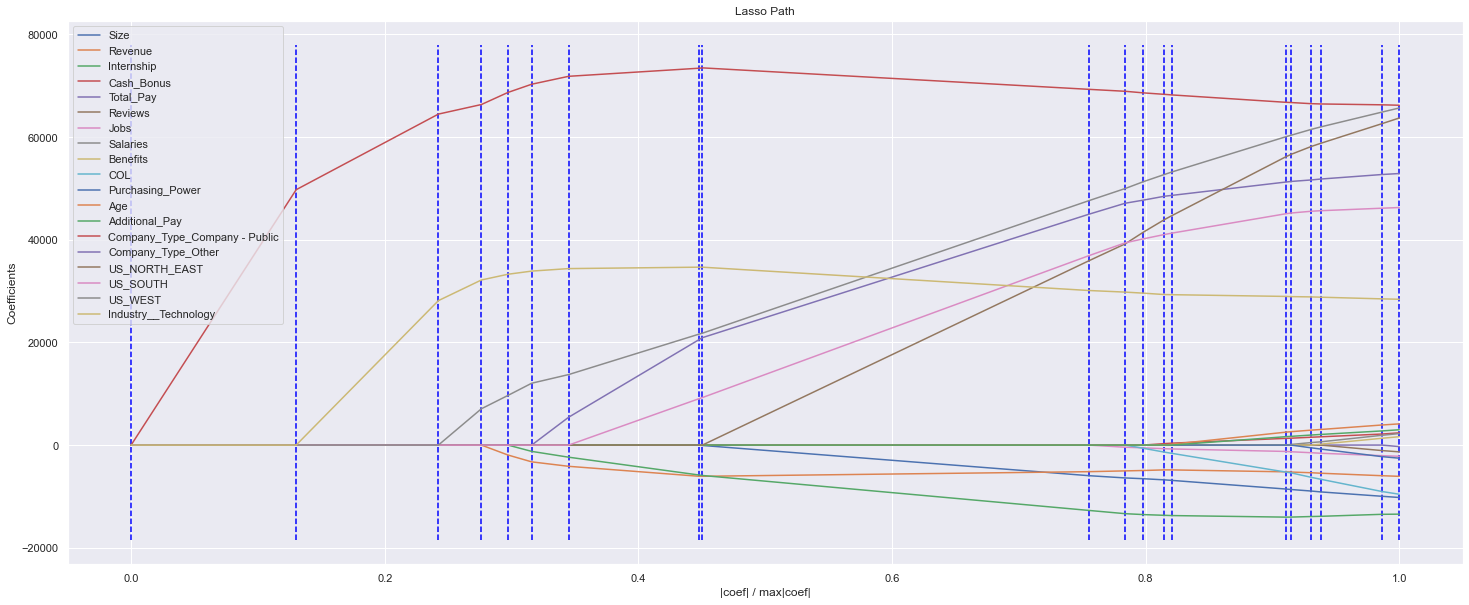

In [30]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(25,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed', color = "blue")
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('Lasso Path')
plt.axis('tight')

plt.legend(X_train.columns)
plt.savefig('Ridge_Lasso_path_train.png')
plt.show()

In [31]:
#Using Ridge on train data 

alphas = 10000**np.linspace(-2,2,100)
Glassdoor_Ridge = RidgeCV(alphas = alphas,
                            cv=5)


Glassdoor_Ridge.fit(X_train, y_train)


RidgeCV(alphas=array([1.00000000e-08, 1.45082878e-08, 2.10490414e-08, 3.05385551e-08,
       4.43062146e-08, 6.42807312e-08, 9.32603347e-08, 1.35304777e-07,
       1.96304065e-07, 2.84803587e-07, 4.13201240e-07, 5.99484250e-07,
       8.69749003e-07, 1.26185688e-06, 1.83073828e-06, 2.65608778e-06,
       3.85352859e-06, 5.59081018e-06, 8.11130831e-06, 1.17681195e-05,
       1.70735265e-05, 2.47707636e-0...
       1.91791026e+04, 2.78255940e+04, 4.03701726e+04, 5.85702082e+04,
       8.49753436e+04, 1.23284674e+05, 1.78864953e+05, 2.59502421e+05,
       3.76493581e+05, 5.46227722e+05, 7.92482898e+05, 1.14975700e+06,
       1.66810054e+06, 2.42012826e+06, 3.51119173e+06, 5.09413801e+06,
       7.39072203e+06, 1.07226722e+07, 1.55567614e+07, 2.25701972e+07,
       3.27454916e+07, 4.75081016e+07, 6.89261210e+07, 1.00000000e+08]),
        cv=5)

In [32]:
#Standardized coefficients found
# when refit using that best alpha
list(zip(X_train.columns, Glassdoor_Ridge.coef_))

[('Size', 1577.241822192196),
 ('Revenue', -582.0076703293867),
 ('Internship', -11478.70513232875),
 ('Cash_Bonus', 1204.5910382973757),
 ('Total_Pay', 6770.473720954844),
 ('Reviews', 1691.2770440643037),
 ('Jobs', 1302.3790169979998),
 ('Salaries', 1672.9306860482527),
 ('Benefits', 619.8648196114382),
 ('COL', 1102.4794321008821),
 ('Purchasing_Power', 1223.7211480353565),
 ('Age', -1540.8058625268175),
 ('Additional_Pay', -26.765137360186976),
 ('Company_Type_Company - Public', 2579.2922806545525),
 ('Company_Type_Other', 607.8260484287423),
 ('US_NORTH_EAST', -3487.899308156377),
 ('US_SOUTH', -1719.1382317117025),
 ('US_WEST', 8438.219039942049),
 ('Industry__Technology', 4122.429637445721)]

In [33]:
# Make predictions on the test set using 
y_pred_ridge = Glassdoor_Ridge.predict(X_val)


# Best alpha value found
print("Alpha: " + str(Glassdoor_Ridge.alpha_))

#derive residuals for the model

residuals_ridge = y_val - y_pred_ridge

#get mae for the model
ridge_mae = mae(y_val, y_pred_ridge)
print("MAE: " + str(ridge_mae))

#get RMSE for the model

ridge_mse = mean_squared_error(y_val, y_pred_ridge)
ridge_rmse = math.sqrt(ridge_mse)

print("RMSE: " + str(ridge_rmse))

#get r2 for ridge model


ridge_r2=r2_score(y_val, y_pred_ridge)
print("R2: " + str(ridge_r2))

#get adjust r2 for the model 
#Adj r2 = 1-(1-R2)*(n-1)/(n-p-1)

ridge_adj_r2 = 1-(1-ridge_r2)*(261-1)/(261-19-1)
print("Adjusted R2: " + str(ridge_adj_r2))

results_df.loc[2] = ["RIDGE", 19, 261, Glassdoor_Ridge.alpha_, ridge_mae,
             ridge_rmse, ridge_r2, ridge_adj_r2]
results_df.head()

Alpha: 34.30469286314926
MAE: 16287.38899286905
RMSE: 21676.121712294986
R2: 0.4074806031028553
Adjusted R2: 0.3607674556296364


,TEST,FEAT,OBS,ALPHA,MAE,RMSE,R2,ADJ_R2
0,XG_BOOST,19,261,0.000000,12049.867322,18931.847837,0.548014,0.512380
1,LASSO,13,261,325.471161,16329.901798,21769.707194,0.402353,0.370898
2,RIDGE,19,261,34.304693,16287.388993,21676.121712,0.407481,0.360767


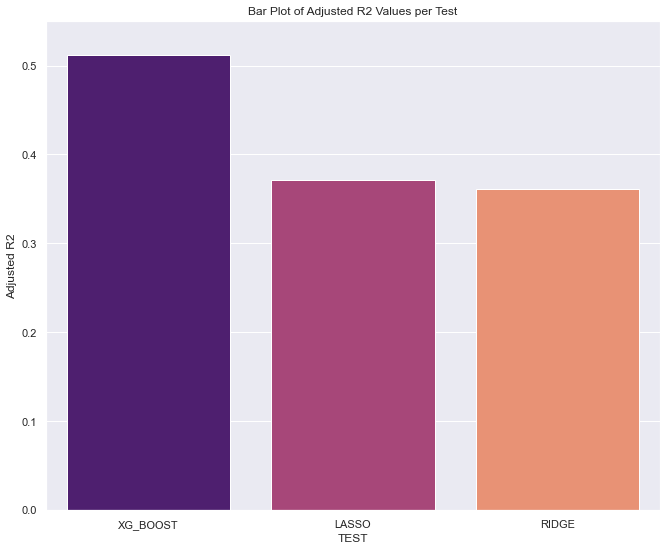

In [34]:
#bar plot of adjusted R2 per test

ax = sns.barplot(x=results_df.TEST,y=results_df.ADJ_R2, palette = 'magma').set_title("Bar Plot of Adjusted R2 Values per Test")
plt.ylim(0.0, 0.55)
plt.ylabel("Adjusted R2")
fig = ax.get_figure()
fig.set_size_inches((11, 9), forward=False)
fig.savefig("Bar_Plot_ADJ_R2.png", dpi=500)

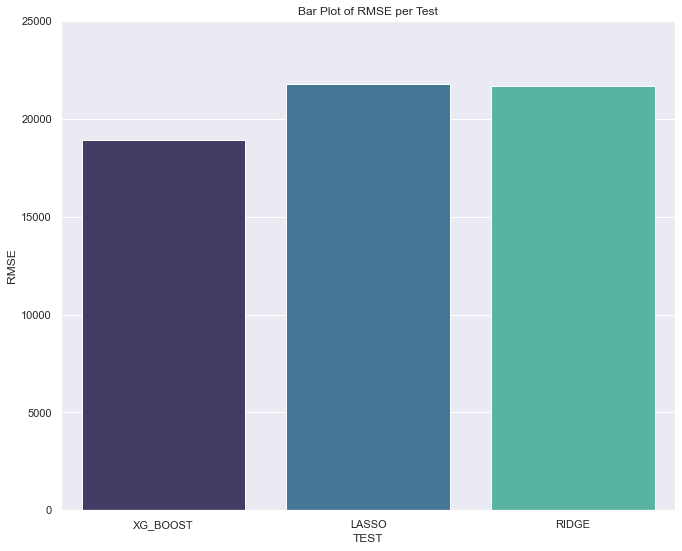

In [35]:
#bar plot of RMSE per test

ax4= sns.barplot(x=results_df.TEST,y=results_df.RMSE, palette = 'mako').set_title("Bar Plot of RMSE per Test")
plt.ylim(0, 25000)
fig = ax4.get_figure()
fig.set_size_inches((11, 9), forward=False)
fig.savefig("Bar_Plot_RMSE.png", dpi=500)


In [36]:
#Create final training set for XGBoost Train on both train & val data 

x_frames = [X_train, X_val]
y_frames = [y_train, y_val]

X_training = pd.concat(x_frames)
y_training = pd.concat(y_frames)




In [37]:
#Tuning Parameters for XG Boost 

#Convert data into DMatrix
glass_dmatrix = xgb.DMatrix(data = X_training, label = y_training)

# Grid of hyperparameters to search over
param_random_gb = {'learning_rate': np.arange(0.05,1.05, 0.05),
              'n_estimators' : [200],
              'subsample' : np.arange(0.05,1.05, 0.05),
                  'alpha': (0.05, 0.1, 0.2, 0.3, 0.5)}

# Regressor Instantiation
gb = xgb.XGBRegressor()

# 25 iterations
mse_random = RandomizedSearchCV(estimator = gb, param_distributions = param_random_gb, n_iter = 25, 
                                scoring = 'neg_mean_squared_error', cv = 4, verbose = 1)

mse_random.fit(X,y)

print("Best parameter: ", mse_random.best_params_)
print("Lowest RMSE: ", np.sqrt(np.abs(mse_random.best_score_)))

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best parameter:  {'subsample': 0.3, 'n_estimators': 200, 'learning_rate': 0.05, 'alpha': 0.05}
Lowest RMSE:  18782.54463934223


In [38]:
#Train final XG Boost Model
xgbr = xgb.XGBRegressor(verbosity=0, eta=0.1, sub_sample=0.8500000000000001, n_estimators=200,
                         alpha=0.5) 
xgbr.fit(X_training, y_training)


#predict y values 
y_pred = xgbr.predict(X_test)

#derive mse, score, mae and adjusted r2
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_rmse = math.sqrt(xgbr_mse)

score = xgbr.score(X_test, y_test)
xgb_mae = mae(y_test, y_pred)

#get adjust r2 for the model 
#Adj r2 = 1-(1-R2)*(n-1)/(n-p-1)
adj_r2 = 1-(1-score) * (261-1)/(261-19-1)

print("MSE: %.2f" % xgb_mse)
print("RMSE: %.2f" % xgb_rmse)
print("MAE Score %.2f" % xgb_mae)
print ("R2 Score: %.2f" % score )
print("Adjusted R2 Score: %.2f" % adj_r2)

results_df.loc[3] = ["XG_BOOST_FINAL", 19, 261, 0.5, xgb_mae,
             xgb_rmse, score, adj_r2]
results_df.head()

MSE: 250637602.64
RMSE: 18931.85
MAE Score 9798.04
R2 Score: 0.69
Adjusted R2 Score: 0.67


,TEST,FEAT,OBS,ALPHA,MAE,RMSE,R2,ADJ_R2
0,XG_BOOST,19,261,0.000000,12049.867322,18931.847837,0.548014,0.512380
1,LASSO,13,261,325.471161,16329.901798,21769.707194,0.402353,0.370898
2,RIDGE,19,261,34.304693,16287.388993,21676.121712,0.407481,0.360767
3,XG_BOOST_FINAL,19,261,0.500000,9798.040791,18931.847837,0.690599,0.666207


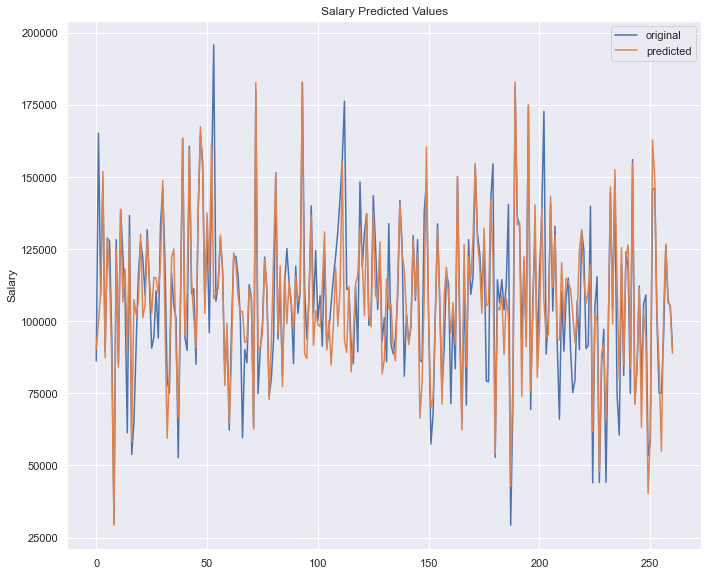

In [39]:
#plot the predictions 

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Salary Predicted Values")
plt.ylabel("Salary")
plt.legend()
f = plt.gcf()
plt.tight_layout()
f.set_size_inches((10, 8), forward=False)


f.savefig('predicted.png', dpi=500, facecolor=fig.get_facecolor(), edgecolor='none')

plt.show()

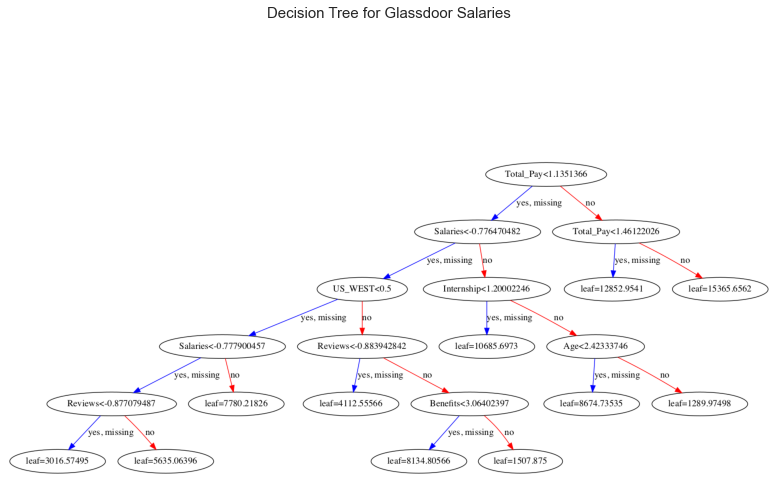

In [40]:
xgb.plot_tree(xgbr,num_trees=0)
plt.rcParams['figure.figsize'] = [20, 20]

f = plt.gcf()
plt.tight_layout()
f.set_size_inches((11, 9), forward=False)

f.suptitle("Decision Tree for Glassdoor Salaries", size=15)
f.savefig('decision_tree.png', dpi=500, facecolor=fig.get_facecolor(), edgecolor='none')


plt.show()

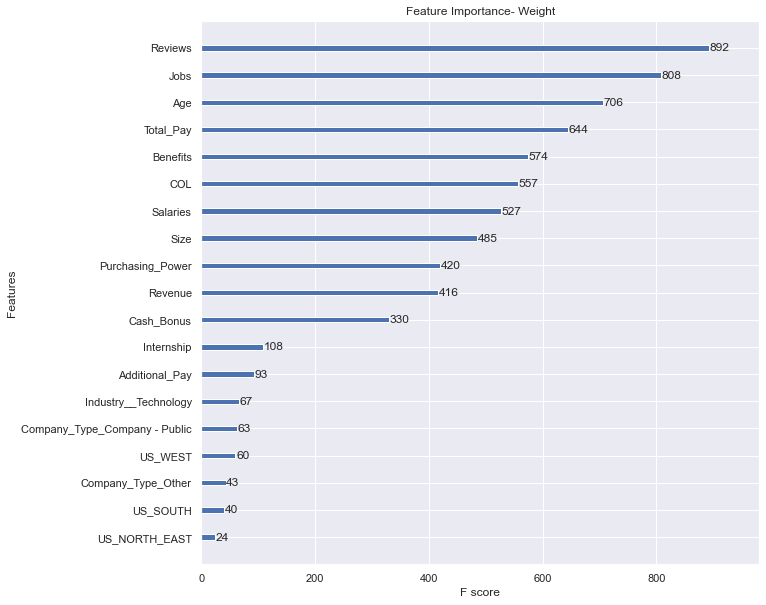

In [41]:
xgb.plot_importance(xgbr, title="Feature Importance- Weight")

f = plt.gcf()

f.set_size_inches((10, 10), forward=False)


f.savefig('feautureimportance_weight.png', dpi=500, facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

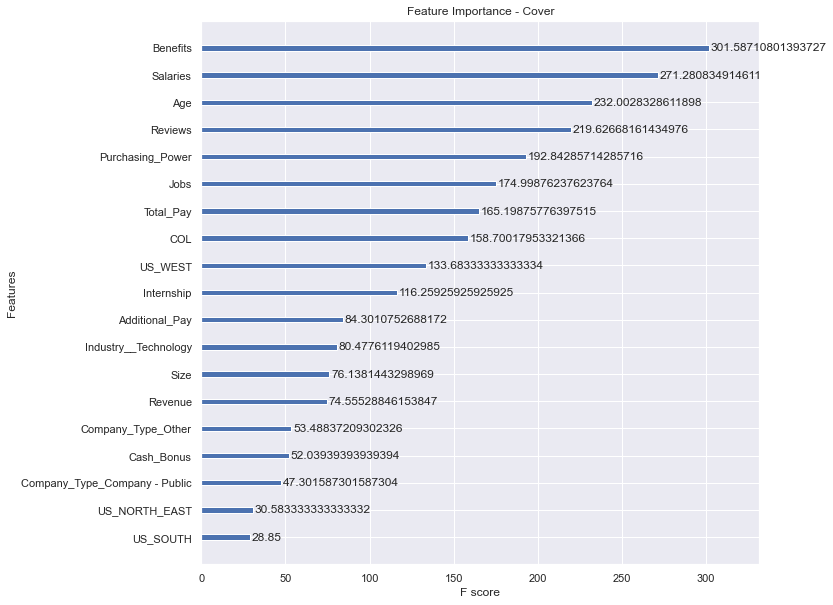

In [42]:
xgb.plot_importance(xgbr, importance_type="cover", title = "Feature Importance - Cover")
f = plt.gcf()

f.set_size_inches((10, 10), forward=False)


f.savefig('feautureimportance_cover.png', dpi=500, facecolor=fig.get_facecolor(), edgecolor='none')

plt.show()

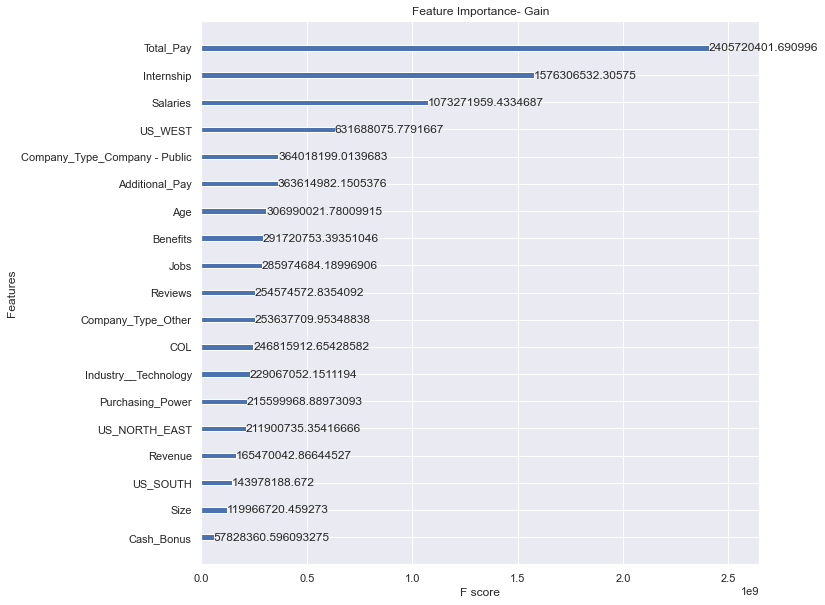

In [43]:
xgb.plot_importance(xgbr, importance_type="gain", title = "Feature Importance- Gain")
f = plt.gcf()

f.set_size_inches((10, 10), forward=False)


f.savefig('feautureimportance_gain.png', dpi=500, facecolor=fig.get_facecolor(), edgecolor='none')

plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


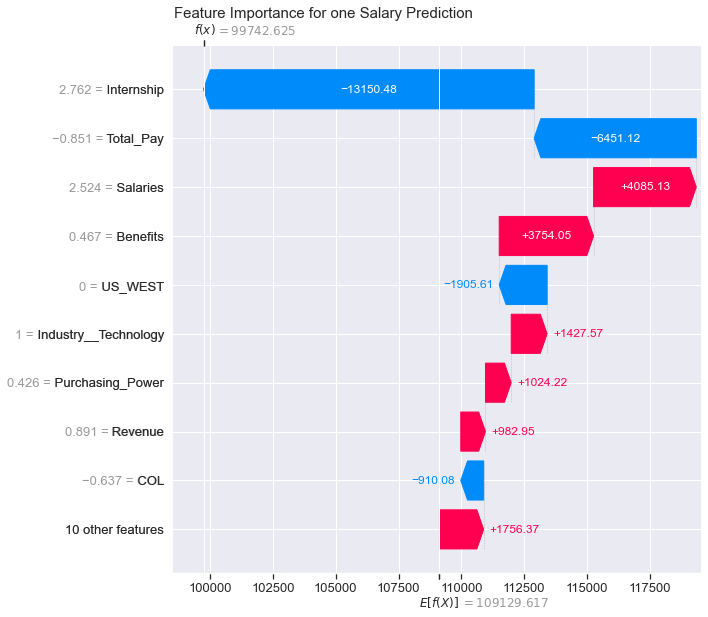

In [44]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(xgbr)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[1], show=False)
f = plt.gcf()
plt.tight_layout()
f.set_size_inches((11, 9), forward=False)

f.suptitle("Feature Importance for one Salary Prediction", size=15)
f.savefig('waterfall.png', dpi=500, facecolor=fig.get_facecolor(), edgecolor='none')


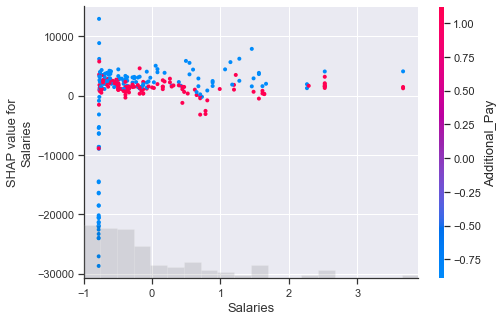

In [45]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"Salaries"], color=shap_values)

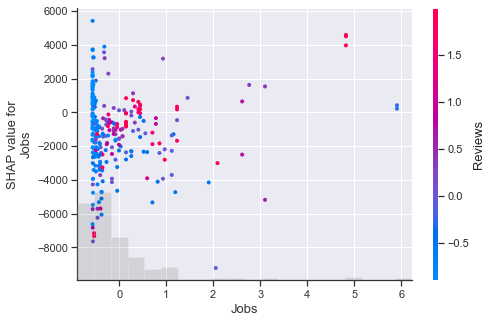

In [46]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"Jobs"], color=shap_values)

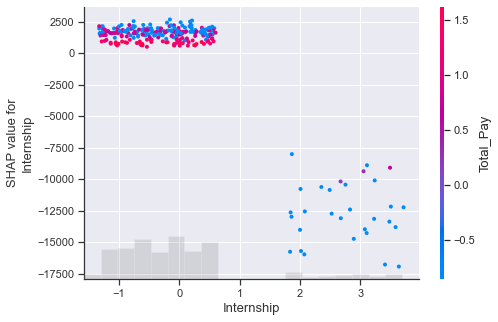

In [47]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,'Internship'], color=shap_values)

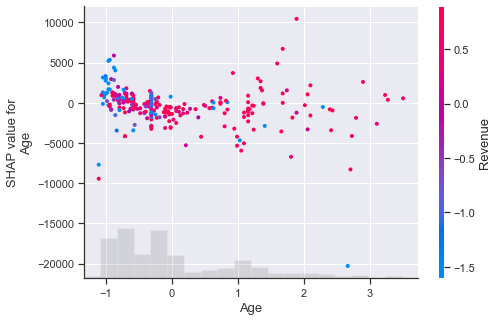

In [48]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"Age"], color=shap_values)

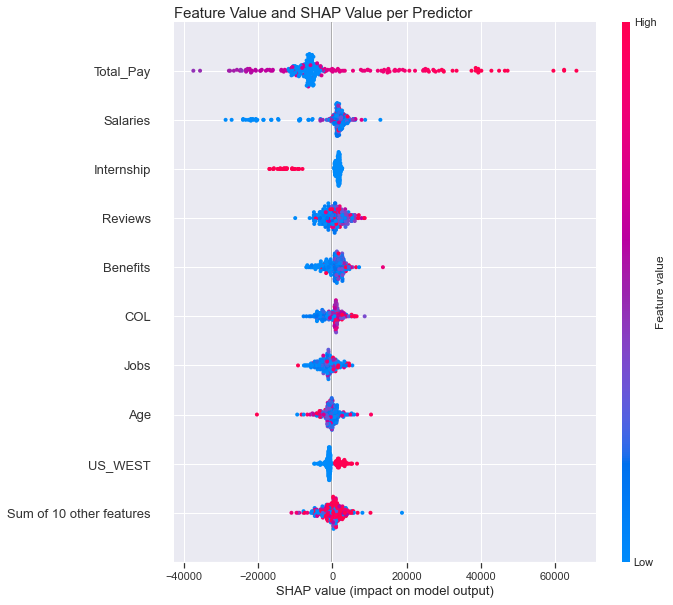

In [49]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, show=False)
f = plt.gcf()
plt.tight_layout()
f.set_size_inches((11, 9), forward=False)

f.suptitle("Feature Value and SHAP Value per Predictor", size=15)
f.savefig('beeswarm.png', dpi=500, facecolor=fig.get_facecolor(), edgecolor='none')

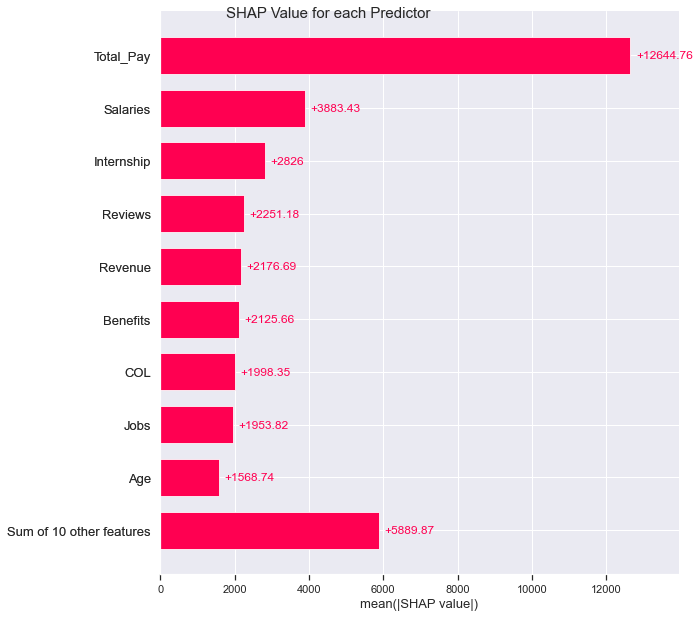

In [50]:
shap.plots.bar(shap_values, show=False)
f = plt.gcf()
plt.tight_layout()
f.set_size_inches((11, 9), forward=False)

f.suptitle("SHAP Value for each Predictor", size=15)
f.savefig('shap_bar.png', dpi=500, facecolor=fig.get_facecolor(), edgecolor='none')


